# Introduction to Weight Quantization
> Reducing the size of Large Language Models with 8-bit quantization

Created by [@maximelabonne](https://twitter.com/maximelabonne).

Modified for CS638 LLM @ wisc

Companion notebook to execute the code from the following article: https://mlabonne.github.io/blog/intro_weight_quantization/

In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch

torch.manual_seed(0)

import lovely_tensors as lt

lt.monkey_patch()

from Quantizer import Quantizer
from utils import *

%load_ext autoreload
%autoreload 2

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig


# Set device to CPU for now
device = 'cpu'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model and tokenizer
model_id = 'gpt2'  # 137m F32 params
# model_id = 'facebook/opt-1.3b' # 1.3b f16 params
# model_id = 'mistralai/Mistral-7B-v0.1'  # 7.24b bf16 params, auth required
# model_id = 'meta-llama/Llama-2-7b-hf' # auth required

model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

model_int8 = AutoModelForCausalLM.from_pretrained(model_id,
                                                  device_map='auto',
                                                  quantization_config=BitsAndBytesConfig(
                                                      load_in_8bit=True)
                                                  )
model_int8.name_or_path += "_int8"

In [4]:
print(f"Model memory size: {model.get_memory_footprint() * 1e-6:.2f} Mb")
print(f"Model int8 memory size: {model_int8.get_memory_footprint() * 1e-6:.2f} Mb")

Model memory size: 510.34 Mb
Model int8 memory size: 176.53 Mb


In [5]:
quantizers = []

In [6]:
def absmax_quantize(X):
    # Calculate scale
    scale = 127 / torch.max(torch.abs(X))

    # Quantize
    X_quant = (scale * X).round()

    # Dequantize
    X_dequant = X_quant / scale

    return X_quant.to(torch.int8), X_dequant


absq = Quantizer(model, tokenizer, absmax_quantize)
quantizers.append(absq)

In [7]:
def zeropoint_quantize(X):
    # Calculate value range (denominator)
    x_range = torch.max(X) - torch.min(X)
    x_range = 1 if x_range == 0 else x_range

    # Calculate scale
    scale = 255 / x_range

    # Shift by zero-point
    zeropoint = (-scale * torch.min(X) - 128).round()

    # Scale and round the inputs
    X_quant = torch.clip((X * scale + zeropoint).round(), -128, 127)

    # Dequantize
    X_dequant = (X_quant - zeropoint) / scale

    return X_quant.to(torch.int8), X_dequant


zpq = Quantizer(model, tokenizer, zeropoint_quantize)
quantizers.append(zpq)

In [8]:
# https://github.com/mit-han-lab/smoothquant
class SmoothQuantMatrix:
    def __init__(self, alpha=0.5):
        self.alpha = alpha

    def smooth_quant_apply(self, X):
        """
        Applies smoothing directly to an input matrix X based on activity scales and returns both quantized and dequantized matrices.

        Args:
            X (torch.Tensor): The input matrix to be smoothed.
            act_scales (torch.Tensor): Activity scales that determine how the input matrix is smoothed.

        Returns:
            torch.Tensor: The smoothed (quantized) matrix.
            torch.Tensor: The dequantized matrix.
        """
        # assert X.dim() == 2, "X must be a 2D matrix"
        # assert X.size(1) == act_scales.numel(), "Mismatch between the number of columns in X and the length of act_scales"

        act_scales = torch.rand(X.shape[-1])

        device, dtype = X.device, X.dtype
        act_scales = act_scales.to(device=device, dtype=dtype)

        # Calculate the weight scales along the columns (features) of X
        weight_scales = X.abs().max(dim=0)[0].clamp(min=1e-5)

        # Compute the scales to adjust the matrix X
        scales = (
            (act_scales.pow(self.alpha) / weight_scales.pow(1 - self.alpha))
            .clamp(min=1e-5)
            .to(device)
            .to(dtype)
        )

        # Apply smoothing to X by element-wise multiplication with scales
        smoothed_X = X * scales

        # Dequantize the matrix by dividing the smoothed matrix by the scales
        dequantized_X = smoothed_X / scales

        return smoothed_X, dequantized_X

smooth_quant = SmoothQuantMatrix(alpha=0.5)

smoothq = Quantizer (model, tokenizer, smooth_quant.smooth_quant_apply)
quantizers.append(smoothq)

In [9]:
# reference: https://github.com/SqueezeAILab/KVQuant/blob/main/quant/kvquant/simquant_module_quantizer.py#L364
import numpy as np
def sim_quantize(X): # bits=8, per_channel=True, qchannel=0, include_sparse=False, sparsity_threshold=0.999, cap_outliers=False
    bits=8
    per_channel=True
    qchannel=0
    include_sparse=False
    sparsity_threshold=0.999
    cap_outliers=False
    if include_sparse:
        threshold = 1 - ((1 - sparsity_threshold) / 2)
    else:
        threshold = 1  # Use full range for min-max quantization

    if per_channel:
        min_vals = X.min(dim=qchannel, keepdim=True)[0]
        max_vals = X.max(dim=qchannel, keepdim=True)[0]
    else:
        min_vals = X.min().expand_as(X)
        max_vals = X.max().expand_as(X)

    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1  # Prevent division by zero

    # Calculate scale and zero point for each channel
    scale = ((2 ** bits - 1) / range_vals).to(X.dtype)
    zero_point = (-min_vals * scale).round().to(X.dtype)

    # Apply quantization
    X_quant = torch.clamp((X * scale + zero_point).round(), 0, 2 ** bits - 1)

    # Dequantization
    X_dequant = (X_quant - zero_point) / scale

    # Cap outliers if requested
    if cap_outliers:
        percentile_low = np.percentile(X.cpu().numpy(), (1 - threshold) * 100)
        percentile_high = np.percentile(X.cpu().numpy(), threshold * 100)
        X_quant = torch.clamp(X_quant, percentile_low, percentile_high)
        X_dequant = (X_quant - zero_point) / scale  # Recalculate dequantized values

    return X_quant.to(torch.int8), X_dequant

simq = Quantizer(model, tokenizer, sim_quantize )
quantizers.append(simq)

In [10]:
from copy import deepcopy
from torch import optim, nn


def sym_quantize_8bit(X):
    """
    Follows:
    https://github.com/microsoft/DeepSpeed/blob/4c15ad9f8d51a1950842c69bbbc9d93c73afbcfc/deepspeed/compression/utils.py#L62
    """
    max_val = torch.max(torch.abs(X))
    scale = max_val / (255 / 2)

    quantized = torch.round(X / scale).clamp(-128, 127)

    # Dequantize
    X_dequant = quantized.float() * scale

    return quantized.to(torch.int8), X_dequant


# layer-by-layer zeroquant
def zeroquant_func(model, tokenizer, quantization_fn=sym_quantize_8bit):
    quant = deepcopy(model)
    input_x = tokenizer.encode("You also have a dream", return_tensors='pt').to(model.device)

    with torch.no_grad():
        teacher_outputs = model(input_x, output_hidden_states=True).hidden_states

    if isinstance(quant, transformers.GPT2LMHeadModel):
        quant_layers = quant.transformer.h
    elif isinstance(quant, transformers.OPTForCausalLM):
        quant_layers = quant.model.decoder.layers
    else:
        raise ValueError("Unsupported model type")

    layer_num = len(quant_layers)

    for layer_idx in range(1, layer_num):
        for i, param in enumerate(quant.parameters()):
            param.requires_grad = (i == layer_idx)  # freeze other layers

        for param in quant_layers[layer_idx].parameters():
            param.data = quantization_fn(param)[1]

        quantized_output = quant_layers[layer_idx](teacher_outputs[layer_idx - 1])[0]

        loss_fn = nn.MSELoss()
        loss = loss_fn(teacher_outputs[layer_idx], quantized_output)

        # update loss
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, quant.parameters()), lr=0.001)
        optimizer.zero_grad()
        loss.requires_grad = True  ## ?? temporary error fixes, conflicts with layer freeze code above

        loss.backward()
        optimizer.step()

        print(f"Loss at layer {layer_idx}: {loss:.4f}")
    return quant


symq = Quantizer(model, tokenizer, sym_quantize_8bit)
zeroq = Quantizer(model, tokenizer, sym_quantize_8bit, zeroquant_func)
quantizers.extend([symq, zeroq])

In [11]:
quantizers

[gpt2_absmax_quantize,
 gpt2_zeropoint_quantize,
 gpt2_smooth_quant_apply,
 gpt2_sim_quantize,
 gpt2_sym_quantize_8bit,
 gpt2_sym_quantize_8bit_zeroquant_func]

Original weights: tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.844, 2.796] μ=5.338e-05 σ=0.200
Quantized (absmax_quantize) weights: tensor[768, 2304] i8 n=1769472 (1.7Mb) x∈[-127, 125] μ=0.003 σ=8.920


/home/yue/.local/lib/python3.12/site-packages/lovely_numpy/repr_plt.py:98: RuntimeWarning: overflow encountered in scalar subtract
  xlim_min -= abs(xlim_max - xlim_min) * 0.02


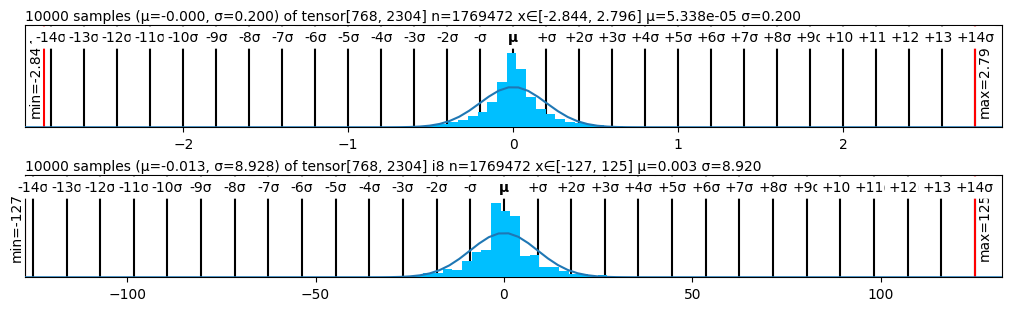

Original weights: tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.844, 2.796] μ=5.338e-05 σ=0.200
Quantized (zeropoint_quantize) weights: tensor[768, 2304] i8 n=1769472 (1.7Mb) x∈[-128, 127] μ=1.003 σ=9.031


/home/yue/.local/lib/python3.12/site-packages/lovely_numpy/repr_plt.py:93: RuntimeWarning: overflow encountered in scalar absolute
  abs_max_value = max(abs(x_min), abs(x_max), 1.)


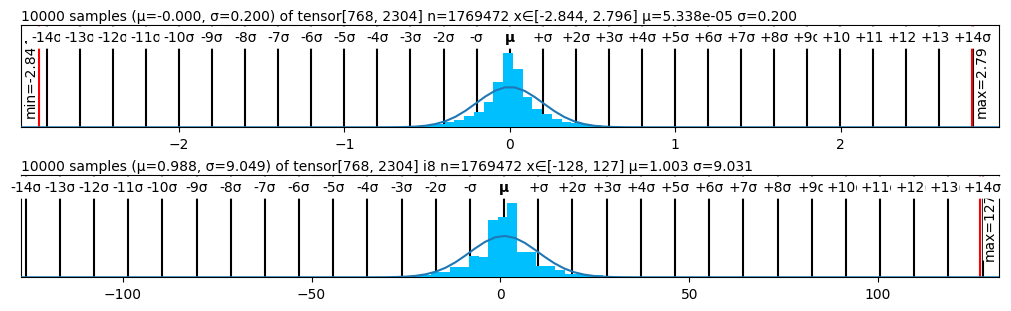

Original weights: tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.844, 2.796] μ=5.338e-05 σ=0.200
Quantized (smooth_quant_apply) weights: tensor[768, 2304] n=1769472 (6.8Mb) x∈[-1.494, 1.405] μ=3.570e-05 σ=0.150


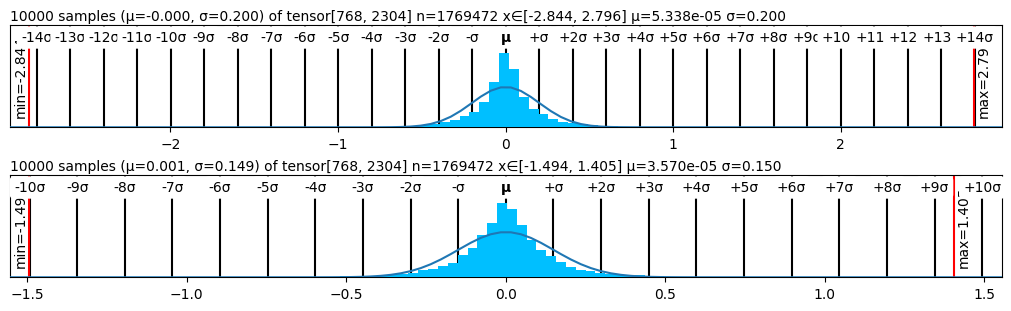

Original weights: tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.844, 2.796] μ=5.338e-05 σ=0.200
Quantized (sim_quantize) weights: tensor[768, 2304] i8 n=1769472 (1.7Mb) x∈[-128, 127] μ=-0.965 σ=100.471


/home/yue/.local/lib/python3.12/site-packages/lovely_numpy/repr_plt.py:116: RuntimeWarning: overflow encountered in scalar subtract
  bins = np.ceil( bins * ( (x.max()-x.min())/(xlims[1]-xlims[0]) ) ).astype(int)


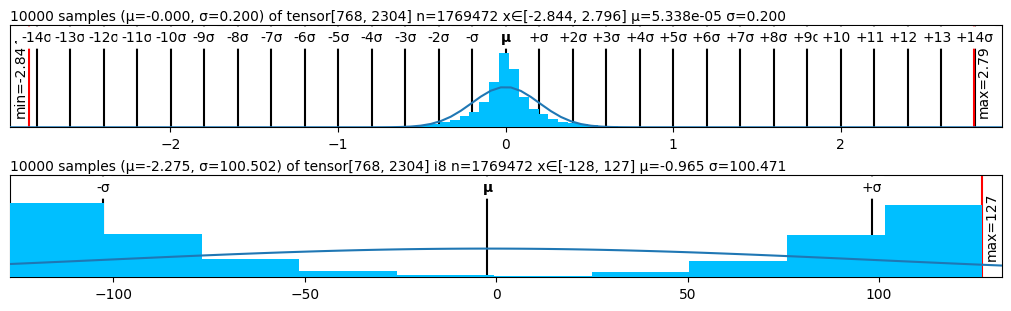

Original weights: tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.844, 2.796] μ=5.338e-05 σ=0.200
Quantized (sym_quantize_8bit) weights: tensor[768, 2304] i8 n=1769472 (1.7Mb) x∈[-128, 125] μ=0.003 σ=8.955


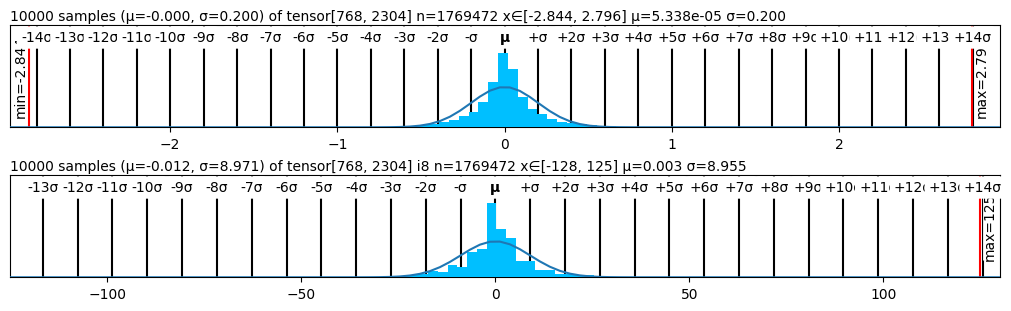

Original weights: tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.844, 2.796] μ=5.338e-05 σ=0.200
Quantized (sym_quantize_8bit_zeroquant_func) weights: tensor[768, 2304] i8 n=1769472 (1.7Mb) x∈[-128, 125] μ=0.003 σ=8.955


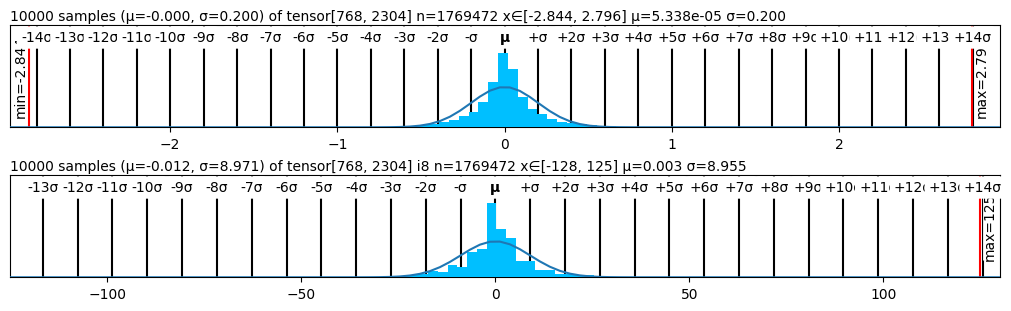

[(tensor[768, 2304] i8 n=1769472 (1.7Mb) x∈[-127, 125] μ=0.003 σ=8.920,
  tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.844, 2.799] μ=5.845e-05 σ=0.200),
 (tensor[768, 2304] i8 n=1769472 (1.7Mb) x∈[-128, 127] μ=1.003 σ=9.031,
  tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.853, 2.786] μ=5.697e-05 σ=0.200),
 (tensor[768, 2304] n=1769472 (6.8Mb) x∈[-1.494, 1.405] μ=3.570e-05 σ=0.150,
  tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.844, 2.796] μ=5.338e-05 σ=0.200),
 (tensor[768, 2304] i8 n=1769472 (1.7Mb) x∈[-128, 127] μ=-0.965 σ=100.471,
  tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.849, 2.791] μ=5.392e-05 σ=0.200),
 (tensor[768, 2304] i8 n=1769472 (1.7Mb) x∈[-128, 125] μ=0.003 σ=8.955,
  tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.855, 2.788] μ=5.915e-05 σ=0.200),
 (tensor[768, 2304] i8 n=1769472 (1.7Mb) x∈[-128, 125] μ=0.003 σ=8.955,
  tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.855, 2.788] μ=5.915e-05 σ=0.200)]

In [12]:
[q.sample_quant() for q in quantizers]

In [13]:
[q.quantize() for q in quantizers]
;

Quantizing...


  0%|          | 0/148 [00:00<?, ?it/s]

Completed, runtime:  0.47
Quantizing...


  0%|          | 0/148 [00:00<?, ?it/s]

Completed, runtime:  0.68
Quantizing...


  0%|          | 0/148 [00:00<?, ?it/s]

Completed, runtime:  0.44
Quantizing...


  0%|          | 0/148 [00:00<?, ?it/s]

Completed, runtime:  0.89
Quantizing...


  0%|          | 0/148 [00:00<?, ?it/s]

Completed, runtime:  0.53
Loss at layer 1: 29.8490
Loss at layer 2: 1616.0979
Loss at layer 3: 2.6665
Loss at layer 4: 1.0428
Loss at layer 5: 1.1299
Loss at layer 6: 0.7993
Loss at layer 7: 0.8660
Loss at layer 8: 0.8760
Loss at layer 9: 1.8217
Loss at layer 10: 18.2502
Loss at layer 11: 2083.8503
Completed, runtime:  0.32


''

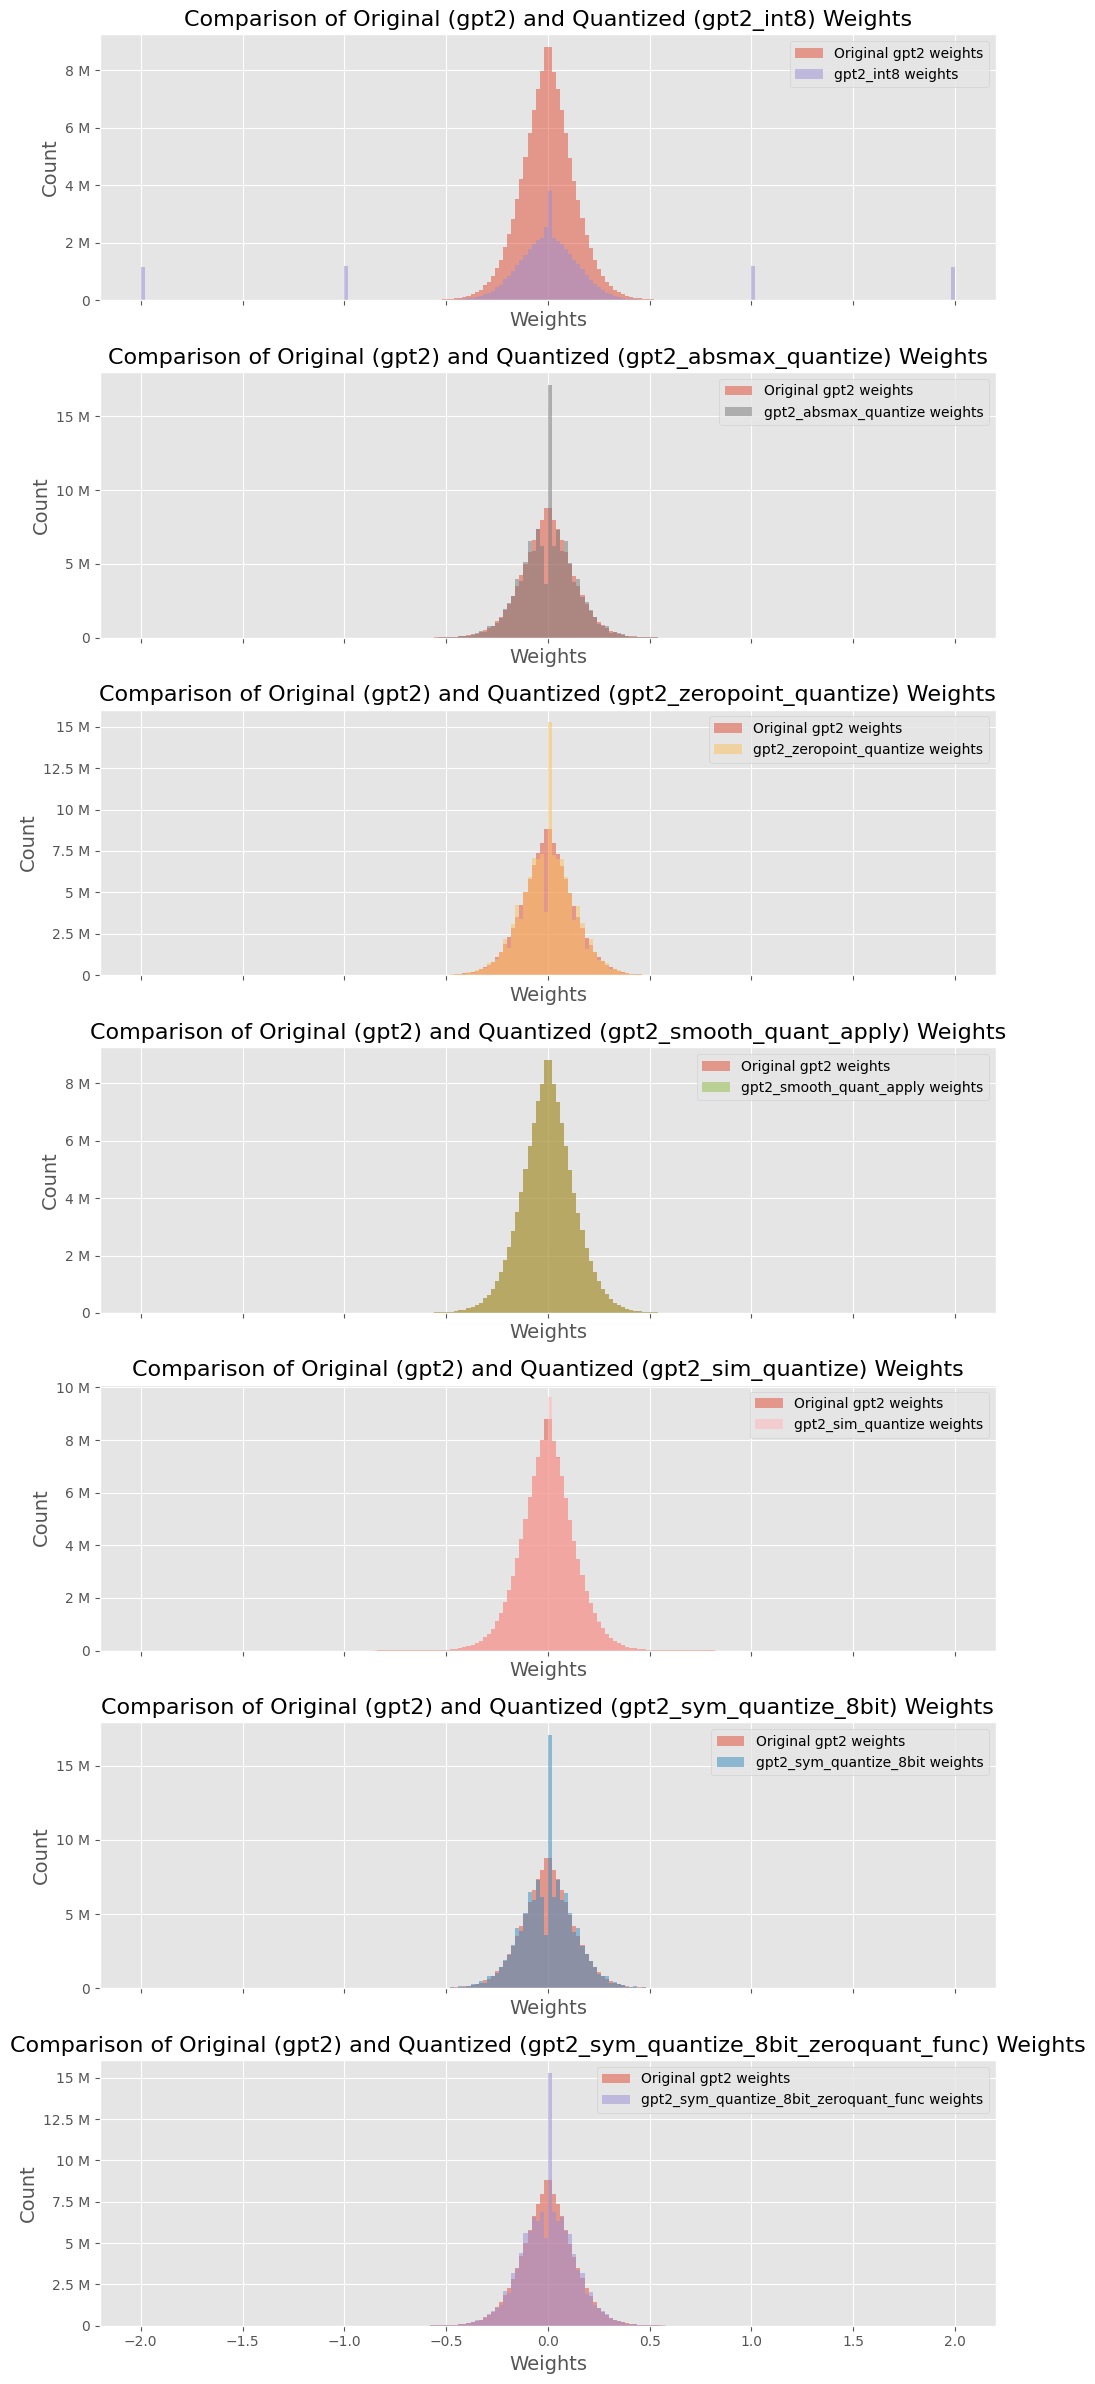

In [14]:
dist_plot([model, model_int8] + [q.quant for q in quantizers])

In [15]:
generated = compare_generation([model, model_int8] + [q.quant for q in quantizers], tokenizer, max_length=200, temperature=0.8)

gpt2:
I have a dream. I want to help people and help my mother and my grandmother as much as I can.

I'm here to help.

I'm here so that it's not just me. I want to inspire people.

I'm here for your mom and my grandmother and my sister and my mom's dad.

I'm here for you and for your mother and my sister and your father and my brother and my brother's father.

I'm here for your uncle and your father and my brother and my brother and my brother and my mother.

I'm here to teach you that there are those in this world that are so good that they can't do any better than they are.

I'm here to tell you that they are great.

I'm here to tell you that there are those in this world that can't do anything better than they are.

I'm here to tell you that they are great
--------------------------------------------------
gpt2_int8:
I have a dream. I don't know what will happen, but tomorrow will be a great day for me!"

"No!"

"I have to be careful with that!"

"What's your dream?"

"I think it's

In [16]:
ppls = compare_ppl([model, model_int8] + [q.quant for q in quantizers], tokenizer, list(generated.values()))

gpt2 ppl: 4.01
gpt2_int8 ppl: 6.83
gpt2_absmax_quantize ppl: 9.32
gpt2_zeropoint_quantize ppl: 8.93
gpt2_smooth_quant_apply ppl: 6.31
gpt2_sim_quantize ppl: 7.16
gpt2_sym_quantize_8bit ppl: 7.01
gpt2_sym_quantize_8bit_zeroquant_func ppl: 7.37
